# Lab:  Model selection for basketball data

In this lab, you will apply polynomial regression with model order selection to a basketball dataset. 

Before doing this lab, you should <u>review the polynomial model selection demo</u> .  In addition to the concepts in that demo, you will learn to:
* Fit a polynomial model for a given model order 
* Select the model order via K-fold cross-validation and the one-standard-error rule.
  

## Loading the data

We first load the standard packages.

In [116]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

We now load the basketball dataset, which we can get from `openml`.

In [117]:
from sklearn.datasets import fetch_openml
basketball = fetch_openml(name="baskball", version=1)

/Users/brianlesko/Documents/VSCode/Machine_Learning/virtualmachine/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Let's turn this dataset into a `pandas` dataframe for ease of handling, and examine the features.

In [118]:
import pandas as pd
df = pd.DataFrame(basketball.data)
df.head()


,assists_per_minute,height,time_played,age
0,0.0888,201,36.02,28
1,0.1399,198,39.32,30
2,0.0747,198,38.80,26
3,0.0983,191,40.71,30
4,0.1276,196,38.40,28


In this lab, we will ignore `basketball.target` and instead investigate the relationship between age and time played.  For this purpose, create the feature vector `x` using the values in the `age` column using the `numpy.array` command.  Similarly, create the target vector `y` using the values in the `time_played` column.

In [119]:
# Age and Time played 
x = np.array(df['age'])
y = np.array(df['time_played'])

# Fitting Models with Different Orders
We will now fit the polynomial model to the data using order d = 1 and order d = 5, for illustration.

For this, we'll use the `polyfit` command of the `numpy.polynomial.polynomial` library.

Text(0, 0.5, 'Time played')

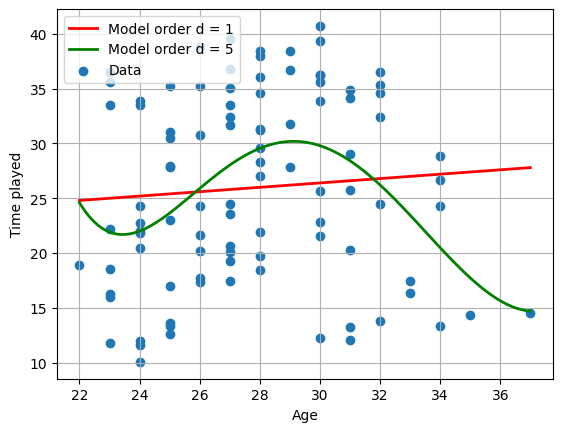

In [120]:
import numpy.polynomial.polynomial as poly
d1 = 1
d2 = 5
beta1 = poly.polyfit(x,y,d1)
beta2 = poly.polyfit(x,y,d2)
xp = np.linspace(22,37,100)
yp_hat1 = poly.polyval(xp,beta1) # target prediction on grid using polynomial order d1
yp_hat2 = poly.polyval(xp,beta2) # target prediction on grid using polynomial order d2

# Make a scatterplot and superimpose prediction curves for d1 and d2
# Add grid lines, axis labels, and a legend

# Prediction Curves
plt.plot(xp,yp_hat1,'r-',linewidth=2,label='Model order d = 1')
plt.plot(xp,yp_hat2,'g-',linewidth=2,label='Model order d = 5')

# Plot data
plt.scatter(x,y,label='Data')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Age')
plt.ylabel('Time played')

How do these two model orders perform?  Are the results as expected? Can we do better?

Model order 5 has a peak around the mean age and decreases after the average age. Which makes this model better than trivial. The Linear model does not agree, and is underfit to the data.

## K-fold Cross-Validation

We now optimize the polynomial model order using 10-fold cross-validation.  You can follow the method used in the polynomial demo.  The first step is to create a matrix of test MSE values over all hypothesized model orders and all splits.  Consider model orders between 0 and 7.

In [121]:
from sklearn.model_selection import KFold
# TODO
# Create a k-fold object
k = 10
kfo = KFold(n_splits=k, shuffle=True)
# Test model orders d between 0 and 7
dtest = np.array(range(0,7))
nd = len(dtest)
MSEts = np.zeros((nd,k))
# Loop over the folds
for isplit, Ind in enumerate(kfo.split(x)): # enumerate returns a counter (isplit) and a list (Ind)
        
    # Get the training data in the split
    Itr, Its = Ind 
    #kfo.split( ) produced Ind, which contains a pair of index sets for each fold 
    xtr = x[Itr]
    ytr = y[Itr]
    xts = x[Its]
    yts = y[Its]
    
    # Loop over the model order
    for it, d in enumerate(dtest):
    
        # Fit data on training data
        beta_hat = poly.polyfit(xtr,ytr,d)
        
        # Measure MSE on test data
        yhat = poly.polyval(xts,beta_hat)
        MSEts[it,isplit] = np.mean((yhat-yts)**2)

Next, compute the mean and standard error of the MSE over the folds for each model order.  <u>The standard error is defined as the standard deviation divided by $\sqrt{K}$, where $K$ is the number of folds</u>.  Use `ddof=1` in `np.std` to get the unbiased version.

With these MSE statistics, use the one-standard-error rule to find the best model order.  Print out the model order that minimizes mean test MSE, as well as the model order estimated by the one-standard-error rule, using the format

    The model order that minimizes mean test MSE is xx
    The model order estimated by the one-standard-error rule is xx

The model order that minimizes mean test MSE is 4


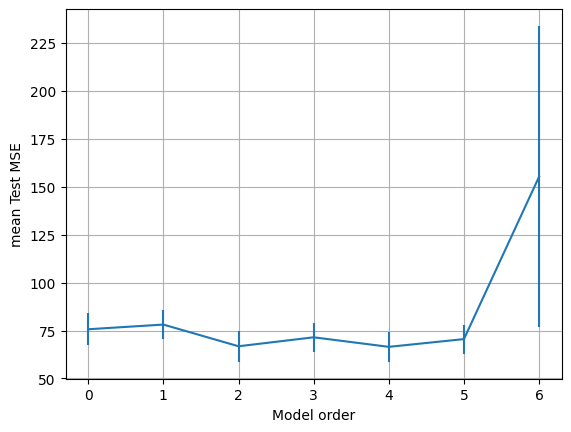

In [122]:
MSE_mean = np.mean(MSEts,axis=1) #note mean is taken over the second dimension, i.e. all folds for the same model order
MSE_se = np.std(MSEts,axis=1,ddof=1)/np.sqrt(k)
plt.errorbar(dtest, MSE_mean, yerr=MSE_se, fmt='-')
plt.xlabel('Model order')
plt.ylabel('mean Test MSE')
plt.grid()

imin = np.argmin(MSE_mean)
print("The model order that minimizes mean test MSE is {0:d}".format(dtest[imin]))

Next, illustrate the one-standard-error-rule procedure by making a plot that shows the following:
* the mean test MSE curve with errorbars
* a dashed line showing the model order yielding minimum mean test MSE
* a dashed line showing the target MSE
* a dashed line showing the model order estimated by the one-standard-error rule

Also, add a grid and axis labels to your plot.  Use `plt.ylim` if needed to zoom into the relevant range.

The model order estimated by the one-standard-error rule is  2


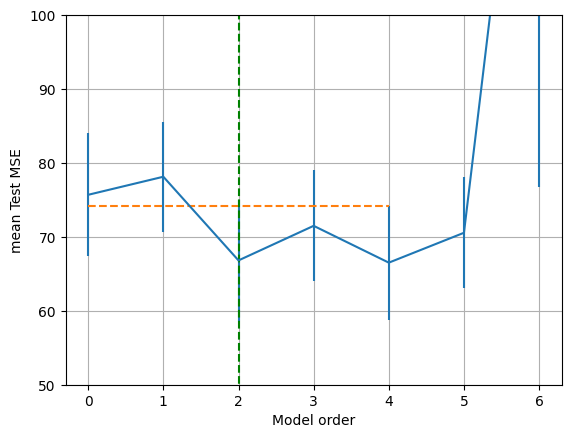

In [127]:
# Find the minimum MSE target
imin = np.argmin(MSE_mean)
MSE_tgt = MSE_mean[imin] + MSE_se[imin]

# Find the lowest model order below the target
I = np.where(MSE_mean <= MSE_tgt)[0]
iose = I[0]
dose = dtest[iose]

plt.errorbar(dtest, MSE_mean, yerr=MSE_se, fmt='-')

# Plot the line at the MSE target
plt.plot([dtest[0],dtest[imin]], [MSE_tgt, MSE_tgt], '--')

# Plot the line at the one-standard-error model estimate
plt.plot([dose,dose], [2,100], 'g--')

plt.xlabel('Model order')
plt.ylabel('mean Test MSE')
plt.grid()
plt.ylim(50,100)

# Print results
print("The model order estimated by the one-standard-error rule is  %d" % dose)

Finally, make a scatter plot of the data and superimpose
* the polynomial prediction curve with the order that minimizes mean MSE
* the polynomial prediction curve with the order selected by the one-standard-error rule

As usual, add grid lines, axis labels, and a legend to your plot.

Text(0, 0.5, 'Time played')

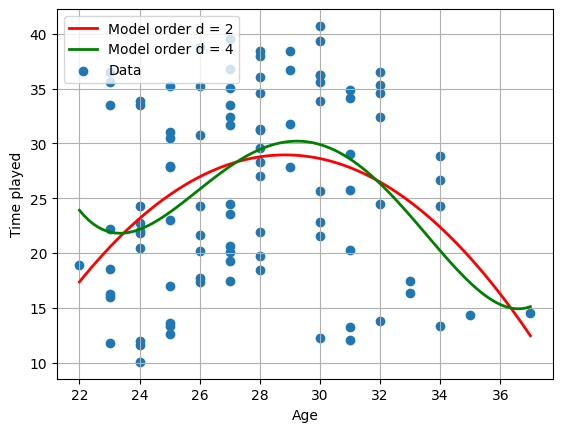

In [129]:
import numpy.polynomial.polynomial as poly
d1 = 2
d2 = 4
beta1 = poly.polyfit(x,y,d1)
beta2 = poly.polyfit(x,y,d2)
xp = np.linspace(22,37,100)
yp_hat1 = poly.polyval(xp,beta1) # target prediction on grid using polynomial order d1
yp_hat2 = poly.polyval(xp,beta2) # target prediction on grid using polynomial order d2

# Make a scatterplot and superimpose prediction curves for d1 and d2
# Add grid lines, axis labels, and a legend

# Prediction Curves
plt.plot(xp,yp_hat1,'r-',linewidth=2,label='Model order d = 2')
plt.plot(xp,yp_hat2,'g-',linewidth=2,label='Model order d = 4')

# Plot data
plt.scatter(x,y,label='Data')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Age')
plt.ylabel('Time played')

Note that because the shuffling done by the K-fold object is random, the results may vary each time you run the code.  If that is distracting, you can fix the `random_seed` of the K-fold object, but remember that the results are just one realization of the random result.